In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Step 1: Load your data from CSV files
def load_data():
    # Load the data and labels from CSV files
    X_train = pd.read_csv('train_data.csv').values
    y_train = pd.read_csv('train_label.csv').values.ravel()  # Flatten the label array if needed
    X_test = pd.read_csv('test_data.csv').values
    y_test = pd.read_csv('test_label.csv').values.ravel()
    X_val = pd.read_csv('val_data.csv').values
    y_val = pd.read_csv('val_label.csv').values.ravel()

    return X_train, y_train, X_test, y_test, X_val, y_val

# Load the data
X_train, y_train, X_test, y_test, X_val, y_val = load_data()

# Standardize the data (important for GMM performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# Step 2: Train GMM for each class using 3 components (3 Gaussians per class)
def train_gmm(X_train, y_train, covariance_type='full'):
    gmm_models = {}
    for class_label in np.unique(y_train):
        # Select data for the current class
        X_class = X_train[y_train == class_label]
        # Create and fit a GMM with 3 Gaussians for this class
        gmm = GaussianMixture(n_components=3, covariance_type=covariance_type, random_state=42)
        gmm.fit(X_class)
        gmm_models[class_label] = gmm
    return gmm_models

In [ ]:
# Step 3: Predict using the GMM models
def predict_gmm(X, gmm_models):
    predictions = []
    for x in X:
        class_probabilities = []
        # Calculate the likelihood for each class
        for class_label, gmm in gmm_models.items():
            class_probabilities.append(gmm.score_samples([x]))  # log probability for x
        # Select the class with the highest log probability
        predictions.append(np.argmax(class_probabilities))
    return np.array(predictions)

In [ ]:
# Step 4: Train and evaluate GMM classifiers
def evaluate_gmm(X_train, X_test, y_train, y_test, covariance_type):
    # Train GMMs
    gmm_models = train_gmm(X_train, y_train, covariance_type)

    # Predict for training data
    y_train_pred = predict_gmm(X_train, gmm_models)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_confusion = confusion_matrix(y_train, y_train_pred)

    # Predict for test data
    y_test_pred = predict_gmm(X_test, gmm_models)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_confusion = confusion_matrix(y_test, y_test_pred)

    # Print and return the results
    print(f"Results for {covariance_type} covariance:")
    print(f"Training accuracy: {train_accuracy}")
    print(f"Test accuracy: {test_accuracy}")
    print("\nTraining Confusion Matrix:\n", train_confusion)
    print("\nTest Confusion Matrix:\n", test_confusion)

    return train_accuracy, test_accuracy, train_confusion, test_confusion

In [ ]:
# Step 5: Run the GMM classifier with full covariance matrices
train_acc_full, test_acc_full, train_conf_full, test_conf_full = evaluate_gmm(X_train, X_test, y_train, y_test, 'full')

Results for full covariance:
Training accuracy: 0.9090042877560743
Test accuracy: 0.4590984974958264

Training Confusion Matrix:
 [[380   8   7   6  18]
 [ 11 382  10   3  14]
 [  5   6 389   8  12]
 [ 15   7  12 367  19]
 [  8   5   9   8 390]]

Test Confusion Matrix:
 [[53 20 12 17 17]
 [27 63 12  6 12]
 [12 18 49 17 24]
 [ 9 12 22 65 12]
 [24 18 25  8 45]]


In [ ]:
# Step 6: Run the GMM classifier with diagonal covariance matrices
train_acc_diag, test_acc_diag, train_conf_diag, test_conf_diag = evaluate_gmm(X_train, X_test, y_train, y_test, 'diag')

Results for diag covariance:
Training accuracy: 0.5359695092901382
Test accuracy: 0.46243739565943237

Training Confusion Matrix:
 [[172  50  61  41  95]
 [ 45 249  34  44  48]
 [ 38  38 251  22  71]
 [ 54  21  58 235  52]
 [ 73  41  59  29 218]]

Test Confusion Matrix:
 [[48 14 16 12 29]
 [23 51 10 16 20]
 [19 10 61 14 16]
 [20  8 18 61 13]
 [18 15 23  8 56]]


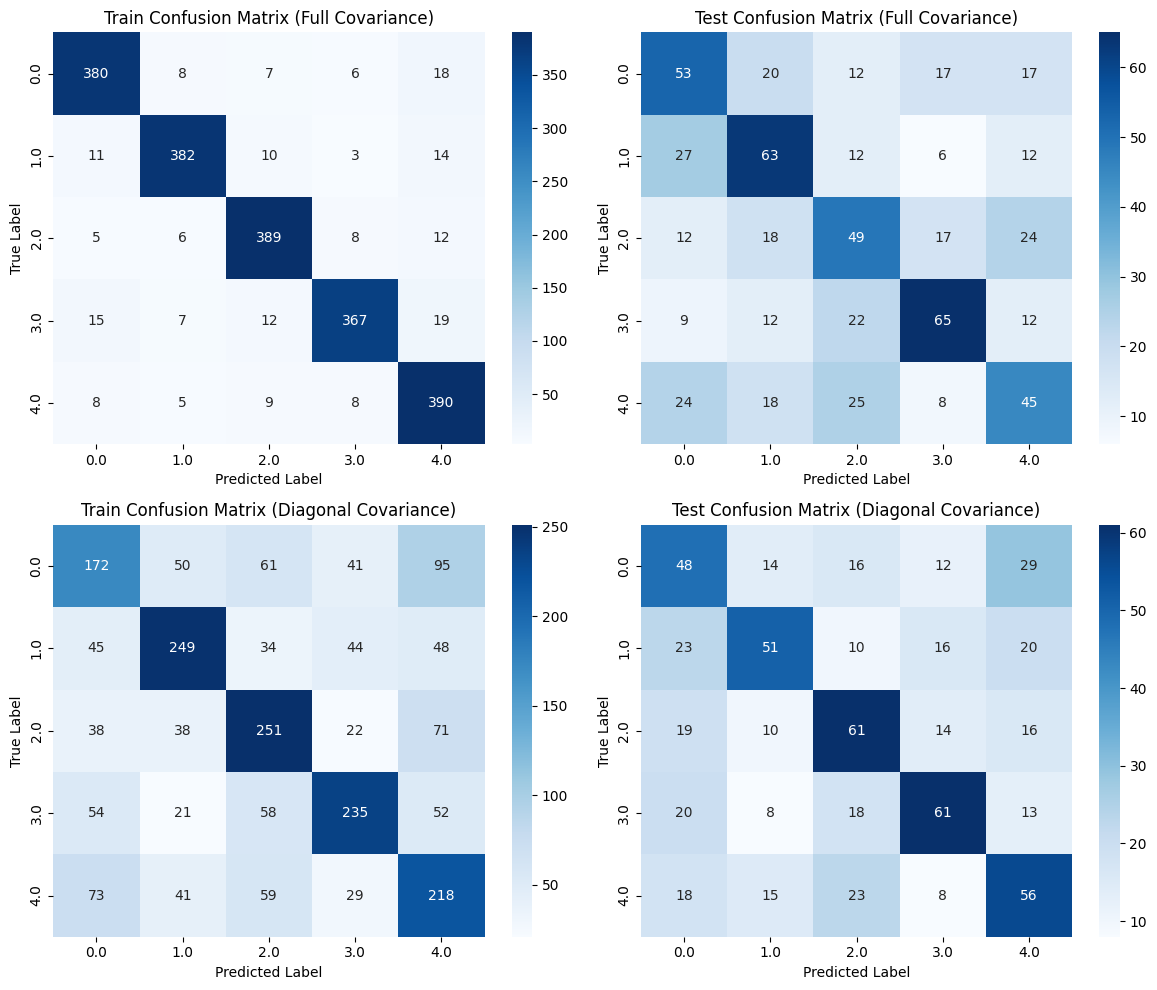

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjusted confusion matrix plot with better display for missing classes
def plot_confusion_matrix(cm, title, labels, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Define the class labels (ensure that they match your data's label values)
class_labels = np.unique(y_train)

# Create subplots: two rows and two columns for both train and test sets in full and diagonal covariance
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot the confusion matrices for train and test, both full and diagonal covariance
plot_confusion_matrix(train_conf_full, title="Train Confusion Matrix (Full Covariance)", labels=class_labels, ax=axs[0, 0])
plot_confusion_matrix(test_conf_full, title="Test Confusion Matrix (Full Covariance)", labels=class_labels, ax=axs[0, 1])
plot_confusion_matrix(train_conf_diag, title="Train Confusion Matrix (Diagonal Covariance)", labels=class_labels, ax=axs[1, 0])
plot_confusion_matrix(test_conf_diag, title="Test Confusion Matrix (Diagonal Covariance)", labels=class_labels, ax=axs[1, 1])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
